In [2]:
import pandas as pd
import numpy as np
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
import matplotlib.pyplot as plt
import C14preproc as prep
import pylab
import C14utils
import matplotlib
import socplot_lib as socplt
import isamcalc_lib as isam
import SOCtools as soc

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
isamcalc_lib.py:116: RuntimeWarning: Mean of empty slice
  val[i, j] = np.nanmean(profile[i, ub:lb])
isamcalc_lib.py:125: RuntimeWarning: Mean of empty slice
  val[i, j] = np.nanmean(profile[i, ub:lb])
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: FutureWarning: Method .as_matrix will be removed in a future version. Use .value

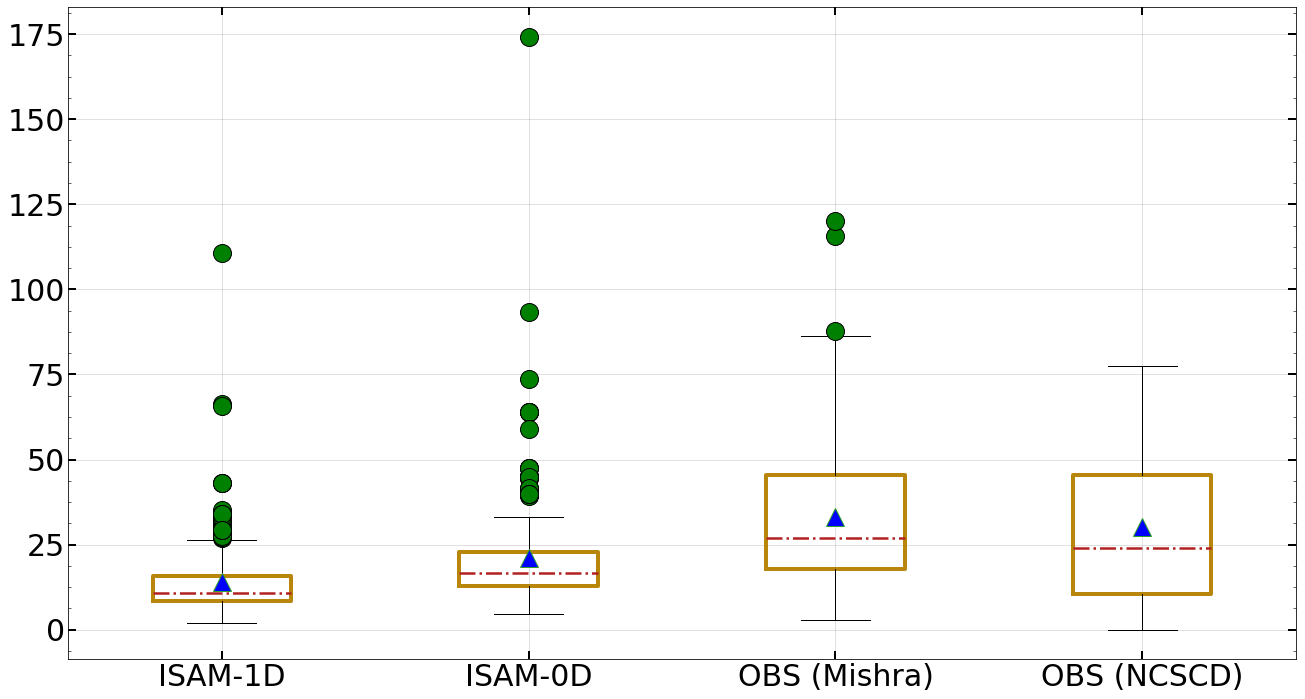

In [3]:
# =====================================================================
#  Plot the simulated SOC profiles for Umakant's samples
#  Compare with the observation also
#  Histel and sites not fitting the model mask are already filtered
# =====================================================================
fobs = "Mishra_soc_interp_197sites.csv"
fmod_pid = "caselist_197sites"
fmod_biome = "pftlist_197sites"
#fmod = "isam_um_soc_highdecomp.dat"
fmod = "isam_um_soc_newclim.dat"
#fmod = "isam_um_soc.dat"
fmod0 = "isam_0d_soc.dat"
fncscd = "NCSCD_extracted_197sites.csv"

# Read in obs
# 197 samples in total
obs = pd.read_csv(fobs, encoding='iso-8859-1', index_col=0)
# Read in the model output
mod = pd.read_csv(fmod, delim_whitespace=True, header=None)
#mod = pd.read_csv(fmod, header=None)
mod_pid = pd.read_csv(fmod_pid, header=None, index_col=0)
mod_biome = pd.read_csv(fmod_biome, header=None, index_col=0)
mod.index = mod_pid.index
# Read in the 0d model output
#mod0 = pd.read_csv(fmod0, delim_whitespace=True, header=None)
mod0 = pd.read_csv(fmod0, header=None)
mod0.index = mod_pid.index
# Read in the NCSCD data product!
ncscd_data = pd.read_csv(fncscd, index_col=0)

sel_profid = mod_pid.index
# Convert the interpolated SOC into ISAM depth
z, dz, zsoih = isam.get_isam_soildp(10)
# obs_as_isam = isam.mean_by_depth(10, zsoih, sel_profid.size, obs_sel.as_matrix())
obs_as_isam = isam.mean_by_depth_sep8(10, zsoih, sel_profid.size, obs.as_matrix())
obs_as_isam[obs_as_isam<=0]=float('nan')
# Unit convert: g/cm3 -> kg/m3
obs_isam = obs_as_isam * 1000.
obs_isam[obs_isam<0.] = float("nan")
# Aggregated SOC density to SOC stock profile till 1m
obs_agg_prof = soc.aggre_profden_to_profstock(10, dz, obs_isam)
# obs_agg = soc.aggre_profden_to_stock(7, dz, obs_isam)
obs_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, obs_isam)

mod_isam = mod.as_matrix()/dz
mod_isam[mod_isam<0.] = float("nan")
mod_agg_prof = soc.aggre_profden_to_profstock(10, dz, mod_isam)
# mod_agg = soc.aggre_profden_to_stock(7, dz, mod_isam)
mod_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, mod_isam)

# Filter out the observation if model did not calculate
# This may not be useful since all the results are available
obs_agg[np.isnan(mod_agg)] = float("nan")
obs_agg_prof[np.isnan(mod_agg_prof)] = float("nan")

mod0[mod0<0] = float("nan")
mod0_agg = mod0.as_matrix().reshape(197)

# Screen out NCSCD observations with the written
ncscd = ncscd_data.NCSCDv2_Ci.as_matrix()
ncscd[np.isnan(mod_agg)] = float("nan")

# Prepare figures
# 1) Barplot of the comparison of the total SOC stock 
# do not separate into different biomes (all in one)
obs_agg_avg = np.nanmean(obs_agg)
mod_agg_avg = np.nanmean(mod_agg)
mod0_avg = np.nanmean(mod0)
# Boxplot of the total SOC in the first 1m
# Shijie: Shall filter out peat before plotting!
data_for_bplot = [mod_agg[~np.isnan(mod_agg)], mod0_agg[~np.isnan(mod0_agg)], obs_agg[~np.isnan(obs_agg)], ncscd[~np.isnan(ncscd)]]

# multiple box plots on one figure
plt.figure(figsize=(22,12))
boxprops = dict(linestyle='-', linewidth=4, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=18,
                  linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
meanprops = dict(marker='^', markerfacecolor='blue', markersize=18,
                  linestyle='none')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

plt.boxplot(data_for_bplot, boxprops=boxprops, flierprops=flierprops, \
           medianprops=medianprops, meanprops=meanprops, showmeans=True) #, meanlineprops=meanlineprops)
plt.xticks([1, 2, 3, 4], ['ISAM-1D', 'ISAM-0D', 'OBS (Mishra)', 'OBS (NCSCD)'], fontsize=30)
plt.yticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=30)
#plt.xlim((0, 9))
#plt.ylim((-500, 500))
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.show()
#plt.savefig('./figures/fig5/fig5a.png')

In [ ]:
# =====================================================================
#  Plot the simulated SOC profiles for Umakant's samples
#  Compare with the observation also
#  Histel and sites not fitting the model mask are already filtered
# =====================================================================
fobs = "Mishra_soc_interp_197sites.csv"
fmod_pid = "caselist_197sites"
fmod_biome = "pftlist_197sites"
fmod = "isam_um_soc.dat"
fmod0 = "isam_0d_soc.dat"
fncscd = "NCSCD_extracted_197sites.csv"

# Read in obs
# 197 samples in total
obs = pd.read_csv(fobs, encoding='iso-8859-1', index_col=0)
# Read in the model output
mod = pd.read_csv(fmod, delim_whitespace=True, header=None)
#mod = pd.read_csv(fmod, header=None)
mod_pid = pd.read_csv(fmod_pid, header=None, index_col=0)
mod_biome = pd.read_csv(fmod_biome, header=None, index_col=0)
mod.index = mod_pid.index
# Read in the 0d model output
#mod0 = pd.read_csv(fmod0, delim_whitespace=True, header=None)
mod0 = pd.read_csv(fmod0, header=None)
mod0.index = mod_pid.index
# Read in the NCSCD data product!
ncscd_data = pd.read_csv(fncscd, index_col=0)

sel_profid = mod_pid.index
# Convert the interpolated SOC into ISAM depth
z, dz, zsoih = isam.get_isam_soildp(10)
# obs_as_isam = isam.mean_by_depth(10, zsoih, sel_profid.size, obs_sel.as_matrix())
obs_as_isam = isam.mean_by_depth_sep8(10, zsoih, sel_profid.size, obs.as_matrix())
obs_as_isam[obs_as_isam<=0]=float('nan')
# Unit convert: g/cm3 -> kg/m3
obs_isam = obs_as_isam * 1000.
obs_isam[obs_isam<0.] = float("nan")
# Aggregated SOC density to SOC stock profile till 1m
obs_agg_prof = soc.aggre_profden_to_profstock(10, dz, obs_isam)
# obs_agg = soc.aggre_profden_to_stock(7, dz, obs_isam)
obs_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, obs_isam)

mod_isam = mod.as_matrix()/dz
mod_isam[mod_isam<0.] = float("nan")
mod_agg_prof = soc.aggre_profden_to_profstock(10, dz, mod_isam)
# mod_agg = soc.aggre_profden_to_stock(7, dz, mod_isam)
mod_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, mod_isam)

# Filter out the observation if model did not calculate
# This may not be useful since all the results are available
obs_agg[np.isnan(mod_agg)] = float("nan")
obs_agg_prof[np.isnan(mod_agg_prof)] = float("nan")

mod0[mod0<0] = float("nan")
mod0_agg = mod0.as_matrix().reshape(197)

# Screen out NCSCD observations with the written
ncscd = ncscd_data.NCSCDv2_Ci.as_matrix()
ncscd[np.isnan(mod_agg)] = float("nan")

# Prepare figures
# 1) Barplot of the comparison of the total SOC stock 
# do not separate into different biomes (all in one)
obs_agg_avg = np.nanmean(obs_agg)
mod_agg_avg = np.nanmean(mod_agg)
mod0_avg = np.nanmean(mod0)
# Boxplot of the total SOC in the first 1m
# Shijie: Shall filter out peat before plotting!
data_for_bplot = [mod_agg[~np.isnan(mod_agg)], mod0_agg[~np.isnan(mod0_agg)], obs_agg[~np.isnan(obs_agg)], ncscd[~np.isnan(ncscd)]]

# multiple box plots on one figure
plt.figure(figsize=(22,12))
boxprops = dict(linestyle='-', linewidth=4, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=18,
                  linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
meanprops = dict(marker='^', markerfacecolor='blue', markersize=18,
                  linestyle='none')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

plt.boxplot(data_for_bplot, boxprops=boxprops, flierprops=flierprops, \
           medianprops=medianprops, meanprops=meanprops, showmeans=True) #, meanlineprops=meanlineprops)
plt.xticks([1, 2, 3, 4], ['ISAM-1D', 'ISAM-0D', 'OBS (Mishra)', 'OBS (NCSCD)'], fontsize=30)
plt.yticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=30)
#plt.xlim((0, 9))
#plt.ylim((-500, 500))
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.show()
#plt.savefig('./figures/fig5/fig5a.png')

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mod_agg[mod_biome.index==5], obs_agg[mod_biome.index==5], color='red')
plt.scatter(mod_agg[mod_biome.index==9], obs_agg[mod_biome.index==9], color='green')
plt.scatter(mod_agg[mod_biome.index==20], obs_agg[mod_biome.index==20], color='red')
plt.scatter(mod_agg[mod_biome.index==8], obs_agg[mod_biome.index==8], color='red')
plt.plot( [0,120],[0,120] )

In [10]:
np.nanmean(mod_agg[mod_biome.index==9])

7.702324496127851

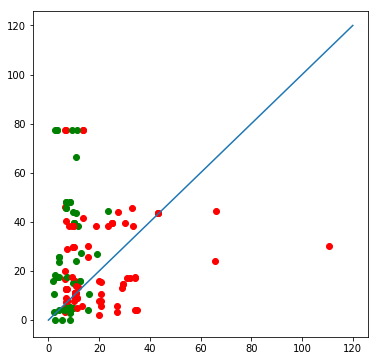

In [4]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mod_agg[mod_biome.index==5], ncscd[mod_biome.index==5], color='red')
plt.scatter(mod_agg[mod_biome.index==9], ncscd[mod_biome.index==9], color='green')
plt.scatter(mod_agg[mod_biome.index==20], ncscd[mod_biome.index==20], color='red')
plt.scatter(mod_agg[mod_biome.index==8], ncscd[mod_biome.index==8], color='red')
plt.plot( [0,120],[0,120] )

In [13]:
mod_agg[41]

110.71147221845047

In [ ]:
# Extract the biome type for non-used sites
fmod_pid = "caselist"
fmod_pid_197 = "caselist_197sites"
fmod_biome = "pftlist"
fmod_biome_197 = "pftlist_197sites"

case_all = np.loadtxt(fmod_pid, dtype='int')
case_use = np.loadtxt(fmod_pid_197, dtype='int')
pft_all = np.loadtxt(fmod_biome, dtype='int')
pft_use = np.loadtxt(fmod_biome_197, dtype='int')
case_nuse = case_all[~np.in1d(case_all, case_use)]
pft_nuse = pft_all[~np.in1d(case_all, case_use)]
#np.savetxt('pftlist_nuse', pft_nuse, fmt='%d')
#np.savetxt('caselist_nuse', case_nuse, fmt='%d')